# Text Normalization

by Michael Hunziker

## Summary
In this notebook we tokenize, stemm and lemmanize our data in order to prepare it as training data for a downstream nlp task.
Then we visualize the data in order to decide upon reasonable stopwords and identify malformed and outlier data that should be removed


*   Tokenize, stemm and lemmanize our data
*   Identify reasonable stopwords
*   Remove malformed data and outliers
*   Save the normalized version




<a href="https://git.com">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
%%capture

!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'

from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.text import join_tokens

import pandas as pd
import numpy as np

In [ ]:
from fhnw.nlp.utils.system import set_log_level
from fhnw.nlp.utils.system import system_info

set_log_level()
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 6.1.85+
Python version: 3.10.12
CPU brand: Intel(R) Xeon(R) CPU @ 2.00GHz
CPU cores: 1
RAM: 12.67GB total and 10.71GB available
Tensorflow version: 2.17.0
GPU is available


In [ ]:
# create a DEV variable to use later
DEV = True

In [ ]:
%%time

!rm "./data/COVIDSenti_cleaned.parq"

download("https://github.com/miam-bonbon/nlp-data/raw/refs/heads/main/data/COVIDSenti_cleaned.parq", "data/COVIDSenti_cleaned.parq")
data = load_dataframe("data/COVIDSenti_cleaned.parq")
data.shape

rm: cannot remove './data/COVIDSenti_cleaned.parq': No such file or directory
CPU times: user 524 ms, sys: 39.3 ms, total: 563 ms
Wall time: 2.14 s


(22516, 4)

In [ ]:
data.head(3)

,tweet,label,cleaned_tweet,lang
2,"TLDR: Not SARS, possibly new coronavirus. Diff...",neg,"TLDR: Not SARS, possibly new coronavirus. Diff...",en
8,@tezuma75 Why #CCP keep on saying unknown caus...,neg,Why #CCP keep on saying unknown cause of pneu...,en
11,I always feel weird hoping for another coronav...,neg,I always feel weird hoping for another coronav...,en


Define our normalization functions (could we use the ones from the library? We'll check later)

In [ ]:
def _tokenize(text, stopwords):
    """Tokenizes and lowercases a text and removes stopwords

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens (in this case tokenization is not applied)
    stopwords : set
        A set of stopword to remove from the tokens

    Returns
    -------
    list
        The tokenized text
    """
    from fhnw.nlp.utils.processing import is_iterable

    if isinstance(text, str):
        from nltk.tokenize import word_tokenize
        word_tokens = word_tokenize(text)
    elif is_iterable(text):
        word_tokens = text
    else:
        raise TypeError("Only string or iterable (e.g. list) is supported. Received a "+ str(type(text)))

    return [word.lower() for word in word_tokens if word.lower() not in stopwords]


def _tokenize_stem(text, stopwords, stemmer):
    """Tokenizes, lowercases and stems a text and removes stopwords

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens (in this case tokenization is not applied)
    stopwords : set
        A set of stopword to remove from the tokens
    stemmer: stemmer
        The stemmer to use (e.g. SnowballStemmer)

    Returns
    -------
    list
        The tokenized and stemmed text
    """
    from fhnw.nlp.utils.processing import is_iterable

    if isinstance(text, str):
        from nltk.tokenize import word_tokenize
        word_tokens = word_tokenize(text)
    elif is_iterable(text):
        word_tokens = text
    else:
        raise TypeError("Only string or iterable (e.g. list) is supported. Received a "+ str(type(text)))

    # if not isinstance(stemmer, Callable):
    stemmer = stemmer.stem

    return [stemmer(word.lower()) for word in word_tokens if word.lower() not in stopwords]


def _tokenize_lemma(text, stopwords, lemmanizer, keep_ners=False):
    """Tokenizes, lowercases and lemmatizes a text and removes stopwords

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens (in this case tokenization is not applied)
    stopwords : set
        A set of stopword to remove from the tokens
    lemmanizer: spacy nlp pipeline
        The lemmanizer to use (must be spacy nlp pipeline)
    keep_ner: bool
        Defines if named entities (NERs) should be keept in one token

    Returns
    -------
    list
        The tokenized and lemmatized text
    """
    from fhnw.nlp.utils.processing import is_iterable

    if isinstance(text, str):
        text = text
    elif is_iterable(text):
        from fhnw.nlp.utils.text import join_tokens
        text = join_tokens(text, set())
    else:
        raise TypeError("Only string or iterable (e.g. list) is supported. Received a "+ str(type(text)))

    if keep_ners:
        # HanoverTagger could be an alternative but takes longer
        # see: https://textmining.wp.hs-hannover.de/Preprocessing.html#Lemmatisierung-und-Wortarterkennung
        doc = lemmanizer(text, disable=['tagger', 'parser'])

        tokens = list()
        ner_idx = 0
        tok_idx = 0

        # keep ner in one token
        while tok_idx < len(doc):
            if ner_idx >= len(doc.ents) or doc[tok_idx].idx < doc.ents[ner_idx].start_char:
                if doc[tok_idx].is_alpha and not doc[tok_idx].is_punct and doc[tok_idx].text.lower() not in stopwords and doc[tok_idx].lemma_.lower() not in stopwords:
                    #print("token ", doc[tok_idx].lemma_.lower())
                    tokens.append(doc[tok_idx].lemma_.lower())

                tok_idx += 1
            else:
                #print("ner ", doc.ents[ner_idx].lemma_.lower())
                tokens.append(doc.ents[ner_idx].lemma_.lower())

                tok_idx += 1
                while tok_idx < len(doc) and doc[tok_idx].idx < doc.ents[ner_idx].end_char:
                    tok_idx += 1

                ner_idx += 1

        return tokens
    else:
        doc = lemmanizer(text, disable=['tagger', 'parser', 'ner'])
        return [tok.lemma_.lower() for tok in doc if tok.is_alpha and not tok.is_punct and tok.text.lower() not in stopwords and tok.lemma_.lower() not in stopwords]


def _normalize(text, stopwords, stemmer=None, lemmanizer=None, lemma_with_ner=False):
    """Normalizes (e.g. tokenize and stem) and lowercases a text and removes stopwords

    Parameters
    ----------
    text : str, iterable
        The text either as string or iterable of tokens (in this case tokenization is not applied)
    stopwords : set
        A set of stopword to remove from the tokens
    stemmer: stemmer
        The stemmer to use (e.g. SnowballStemmer) or None to disable stemming
    lemmanizer: spacy nlp pipeline
        The lemmanizer to use (must be spacy nlp pipeline) or None to disable lemmantization
    lemma_with_ner: bool
        Defines if named entities (NERs) should be keept in one token

    Returns
    -------
    list
        The normalized text
    """

    if lemmanizer is not None:
        return _tokenize_lemma(text, stopwords, lemmanizer, keep_ners=lemma_with_ner)
    elif stemmer is not None:
        return _tokenize_stem(text, stopwords, stemmer)
    else:
        return _tokenize(text, stopwords)

Let's use a spacy model (https://spacy.io/models/en#en_core_web_md)

In [ ]:
%%capture

!pip install 'spacy>=3.0.5'
!pip install nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import spacy
!python3 -m spacy download en_core_web_md

nlp = spacy.load("en_core_web_md")

import nltk
nltk.download('punkt')
nltk.download('stopwords')

stemmer = SnowballStemmer("english")
stopwords = set(stopwords.words("english"))
#stopwords = set(nlp.Defaults.stop_words)
empty_stopwords = set()

In [ ]:
print(stopwords)

{'myself', 'mightn', 'whom', 'same', 'couldn', 'until', 'is', 'ain', 'theirs', 'does', "should've", 'over', 'won', 'as', 'me', 'been', 'o', 'your', 'mustn', 'here', 'between', "you're", 'needn', 'd', 'off', 'doesn', 'his', 'more', "needn't", 'i', 'an', 'and', 're', 'up', 'if', 'out', 'be', 'these', 'with', "didn't", "couldn't", 'than', 'each', 'by', 'aren', 'has', 'did', 'about', "she's", 'a', 'into', "weren't", 't', 'wouldn', 'hadn', 'we', 'not', 'after', 'will', "it's", 'no', 'while', "don't", 'against', 'during', 'because', 'to', "that'll", 'from', 'was', 'at', 'this', 'didn', 'now', 'those', 'should', 'haven', 'yours', 'are', 'under', 'on', 'of', 'down', 'both', "you'd", 'can', 'or', 'for', "aren't", "hasn't", 'were', 'am', 'then', 'there', 'who', 'other', 'so', 'hasn', 'very', "shan't", 'my', "haven't", 'nor', 'any', "you'll", 'own', "mightn't", 'they', "you've", 'how', 'its', 'in', 'which', 'only', 'what', 'before', 'ma', 'weren', 'too', 'further', 'their', 'wasn', 'himself', 'bu

Let's test some examples:

In [ ]:
print(_tokenize("Coronavirus is that when youve had too many #Coronas ", stopwords=stopwords))
print(_tokenize_stem("The Frieman Scary Scale makes its debut. Wuhan Coronavirus scores  out of  N masks.", stopwords=stopwords, stemmer=stemmer))

['coronavirus', 'youve', 'many', '#', 'coronas']
['frieman', 'scari', 'scale', 'make', 'debut', '.', 'wuhan', 'coronavirus', 'score', 'n', 'mask', '.']


In [ ]:
%%time
data = data[data.columns.drop(list(data.filter(regex='token_clean')))] # we always append
data = parallelize_dataframe(data, _normalize, field_read="cleaned_tweet", field_write="token_clean", stopwords=stopwords, stemmer=None, lemmanizer=None, lemma_with_ner=False)

CPU times: user 4.98 s, sys: 38.5 ms, total: 5.02 s
Wall time: 5.97 s


Now let's use the library

In [ ]:
%%time

from fhnw.nlp.utils.normalize import normalize, tokenize, tokenize_lemma, tokenize_stem

data = data[data.columns.drop(list(data.filter(regex='token_clean')))] # we always append
data = parallelize_dataframe(data, normalize, field_read="cleaned_tweet", field_write="token_clean", stopwords=stopwords, stemmer=None, lemmanizer=None, lemma_with_ner=False)

CPU times: user 3.43 s, sys: 8.52 ms, total: 3.44 s
Wall time: 3.45 s


yep, also working

Get the (lowercased) tokens first without removing stopwords in order to come up with a reasonable set of stopwords.

In [ ]:
%%time
data = parallelize_dataframe(data, normalize, field_read="cleaned_tweet", field_write="token_no_stopwords_clean", stopwords=empty_stopwords, stemmer=None, lemmanizer=None, lemma_with_ner=False)

CPU times: user 3.44 s, sys: 35.7 ms, total: 3.47 s
Wall time: 3.47 s


We also later need text instead of tokens

In [ ]:
%%time
data = parallelize_dataframe(data, join_tokens, field_read="token_clean", field_write="text_clean", stopwords=empty_stopwords)

CPU times: user 42.5 ms, sys: 5.71 ms, total: 48.2 ms
Wall time: 53.7 ms


In [ ]:
data.head(3)

,tweet,label,cleaned_tweet,lang,token_no_stopwords_clean,text_clean,token_clean,token_no_stopwords_clean,text_clean
2,"TLDR: Not SARS, possibly new coronavirus. Diff...",neg,"TLDR: Not SARS, possibly new coronavirus. Diff...",en,"[tldr, :, not, sars, ,, possibly, new, coronav...","tldr : not sars , possibly new coronavirus . d...","[tldr, :, sars, ,, possibly, new, coronavirus,...","[tldr, :, not, sars, ,, possibly, new, coronav...","tldr : sars , possibly new coronavirus . diffi..."
8,@tezuma75 Why #CCP keep on saying unknown caus...,neg,Why #CCP keep on saying unknown cause of pneu...,en,"[why, #, ccp, keep, on, saying, unknown, cause...",why # ccp keep on saying unknown cause of pneu...,"[#, ccp, keep, saying, unknown, cause, pneumon...","[why, #, ccp, keep, on, saying, unknown, cause...",# ccp keep saying unknown cause pneumonia ? ca...
11,I always feel weird hoping for another coronav...,neg,I always feel weird hoping for another coronav...,en,"[i, always, feel, weird, hoping, for, another,...",i always feel weird hoping for another coronav...,"[always, feel, weird, hoping, another, coronav...","[i, always, feel, weird, hoping, for, another,...",always feel weird hoping another coronavirus o...


Store the work so far (so we could resume if needed).

In [ ]:
%%time

import pandas as pd
from google.colab import drive

if (DEV):
  # Mount Google Drive
  drive.mount('/content/drive')
  output_file_path = "/content/drive/MyDrive/COVIDSenti_tokenized_01.parq"  # Replace with your desired path

  # Save the DataFrame to Parquet format
  data.to_parquet(output_file_path)

  save_dataframe(data, "data/COVIDSenti_tokenized_01.parq")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CPU times: user 1.17 s, sys: 50.3 ms, total: 1.22 s
Wall time: 4.15 s


Here we reload if we work from here

In [ ]:
from google.colab import drive

if (data.empty):
  # Mount Google Drive
  drive.mount('/content/drive')
  input_file_path = "/content/drive/MyDrive/COVIDSenti_tokenized_01.parq"  # Replace with your desired path

  # Save the DataFrame to Parquet format
  data = pd.read_parquet(input_file_path)

  save_dataframe(data, "data/COVIDSenti_tokenized_01.parq")

Let's see how frequent the words (and their n-grams) are

In [ ]:
from collections import Counter

def plot_ngram_counts(counter, n_most_common, title="Term frequencies"):
    """Plots the n-gram counts

    Parameters
    ----------
    counter : Counter
        The counter of the n-grams
    n_most_common : int
        The n most common n-grams to plot
    title : str
        The title of the plot
    """

    import matplotlib.pyplot as plt

    y = [count for tag, count in counter.most_common(n_most_common)]
    x = [tag for tag, count in counter.most_common(n_most_common)]

    plt.bar(x, y)
    plt.title(title)
    plt.ylabel("Frequency")
    #plt.yscale('log') # set log scale for y-axis
    plt.xticks(rotation=90)
    for i, (tag, count) in enumerate(counter.most_common(n_most_common)):
        plt.text(i, count, f' {count} ', rotation=90, ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
    plt.xlim(-0.6, len(x)-0.4) # set tighter x lims
    plt.tight_layout() # change the whitespace such that all labels fit nicely
    plt.show()

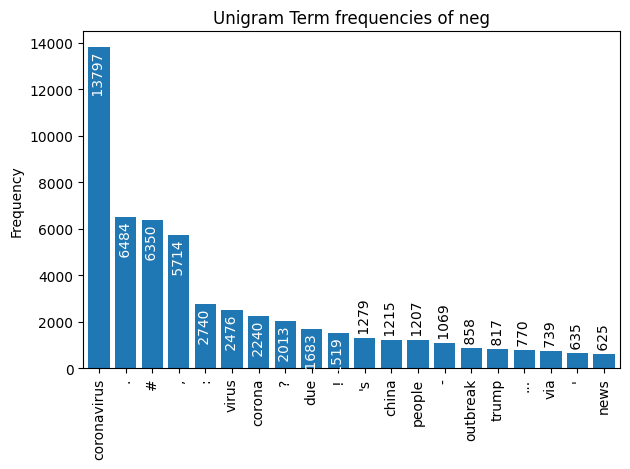

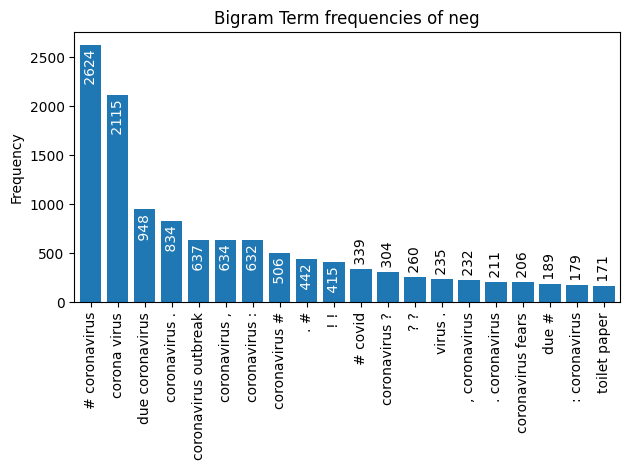

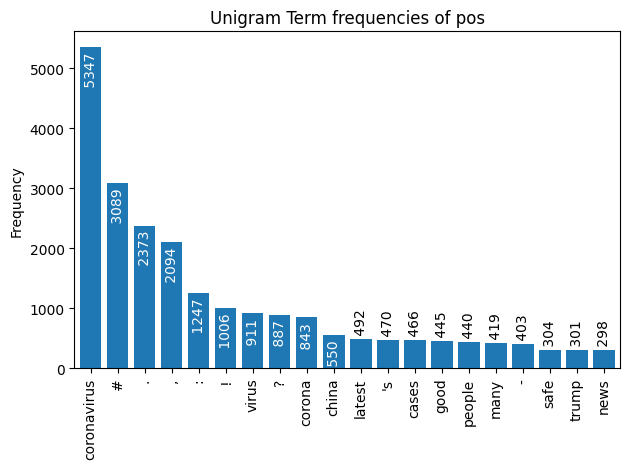

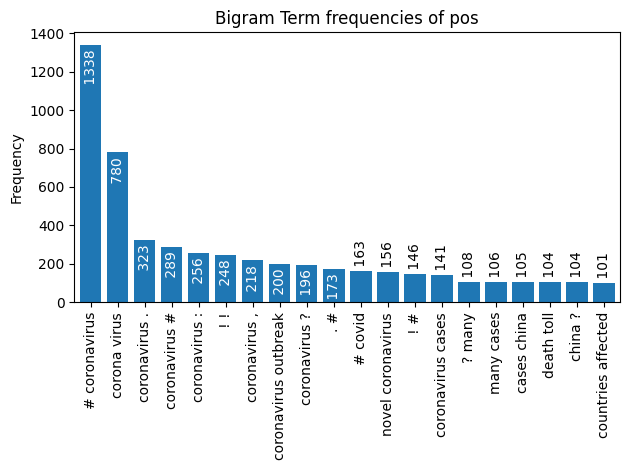

In [ ]:
from fhnw.nlp.utils.text import create_ngram_counts

for label in data["label"].unique():
  ngrams_1 = create_ngram_counts(data.loc[(data["label"] == label)], 1, "token_clean")
  ngrams_2 = create_ngram_counts(data.loc[(data["label"] == label)], 2, "token_clean")

  plot_ngram_counts(ngrams_1, 20, "Unigram Term frequencies of "+label)
  plot_ngram_counts(ngrams_2, 20, "Bigram Term frequencies of "+label)

Doesn't look right, let's reunite the hashtags

In [ ]:
import pandas as pd
import re

def remove_space_after_hash(text):
  """Removes spaces between '#' and the following word."""
  return re.sub(r'#\s+(\w+)', r'#\1', text)

def process_dataframe(df, column_name):
    """Applies the space removal function to a specified column in a Pandas DataFrame."""
    df[column_name] = df[column_name].astype(str).apply(remove_space_after_hash)
    return df

data = process_dataframe(data, 'cleaned_tweet')

In [ ]:
data.head(10)

,tweet,label,cleaned_tweet,lang,token_no_stopwords_clean,text_clean,token_clean,token_no_stopwords_clean,text_clean
2,"TLDR: Not SARS, possibly new coronavirus. Diff...",neg,"TLDR: Not SARS, possibly new coronavirus. Diff...",en,"[tldr, :, not, sars, ,, possibly, new, coronav...","tldr : not sars , possibly new coronavirus . d...","[tldr, :, sars, ,, possibly, new, coronavirus,...","[tldr, :, not, sars, ,, possibly, new, coronav...","tldr : sars , possibly new coronavirus . diffi..."
8,@tezuma75 Why #CCP keep on saying unknown caus...,neg,Why #CCP keep on saying unknown cause of pneu...,en,"[why, #, ccp, keep, on, saying, unknown, cause...",why # ccp keep on saying unknown cause of pneu...,"[#, ccp, keep, saying, unknown, cause, pneumon...","[why, #, ccp, keep, on, saying, unknown, cause...",# ccp keep saying unknown cause pneumonia ? ca...
11,I always feel weird hoping for another coronav...,neg,I always feel weird hoping for another coronav...,en,"[i, always, feel, weird, hoping, for, another,...",i always feel weird hoping for another coronav...,"[always, feel, weird, hoping, another, coronav...","[i, always, feel, weird, hoping, for, another,...",always feel weird hoping another coronavirus o...
16,@KariDebbink @Vineet321 The Frieman Scary Scal...,neg,The Frieman Scary Scale makes its debut. Wuh...,en,"[the, frieman, scary, scale, makes, its, debut...",the frieman scary scale makes its debut . wuha...,"[frieman, scary, scale, makes, debut, ., wuhan...","[the, frieman, scary, scale, makes, its, debut...",frieman scary scale makes debut . wuhan corona...
18,"Crap, a quick blast search suggests the Wuhan ...",neg,"Crap, a quick blast search suggests the Wuhan ...",en,"[crap, ,, a, quick, blast, search, suggests, t...","crap , a quick blast search suggests the wuhan...","[crap, ,, quick, blast, search, suggests, wuha...","[crap, ,, a, quick, blast, search, suggests, t...","crap , quick blast search suggests wuhan coron..."
24,China releases genetic data on new coronavirus...,neg,China releases genetic data on new coronavirus...,en,"[china, releases, genetic, data, on, new, coro...",china releases genetic data on new coronavirus...,"[china, releases, genetic, data, new, coronavi...","[china, releases, genetic, data, on, new, coro...","china releases genetic data new coronavirus , ..."
31,"Brace yourself #America, this virus is nasty &...",neg,"Brace yourself #America, this virus is nasty &...",en,"[brace, yourself, #, america, ,, this, virus, ...","brace yourself # america , this virus is nasty...","[brace, #, america, ,, virus, nasty, &, killer...","[brace, yourself, #, america, ,, this, virus, ...","brace # america , virus nasty & killer . # # c..."
49,Wtf is #coronavirus,neg,Wtf is #coronavirus,en,"[wtf, is, #, coronavirus]",wtf is # coronavirus,"[wtf, #, coronavirus]","[wtf, is, #, coronavirus]",wtf # coronavirus
55,„ÇΩ„Éº„Çπ\nChina coronavirus: at least three s...,neg,China coronavirus: at least three suspected c...,en,"[china, coronavirus, :, at, least, three, susp...",china coronavirus : at least three suspected c...,"[china, coronavirus, :, least, three, suspecte...","[china, coronavirus, :, at, least, three, susp...",china coronavirus : least three suspected case...
61,YVR on alert for deadly coronavirus spreading ...,neg,YVR on alert for deadly coronavirus spreading ...,en,"[yvr, on, alert, for, deadly, coronavirus, spr...",yvr on alert for deadly coronavirus spreading ...,"[yvr, alert, deadly, coronavirus, spreading, c...","[yvr, on, alert, for, deadly, coronavirus, spr...",yvr alert deadly coronavirus spreading china


and reprocess

In [ ]:
%%time
from fhnw.nlp.utils.normalize import normalize, tokenize, tokenize_lemma, tokenize_stem

data = data[data.columns.drop(list(data.filter(regex='token_clean')))] # we always append
data = parallelize_dataframe(data, normalize, field_read="cleaned_tweet", field_write="token_clean", stopwords=stopwords, stemmer=None, lemmanizer=None, lemma_with_ner=False)

data = data[data.columns.drop(list(data.filter(regex='token_no_stopwords_clean')))] # we always append
data = parallelize_dataframe(data, normalize, field_read="cleaned_tweet", field_write="token_no_stopwords_clean", stopwords=empty_stopwords, stemmer=None, lemmanizer=None, lemma_with_ner=False)

data = data[data.columns.drop(list(data.filter(regex='text_clean')))] # we always append
data = parallelize_dataframe(data, join_tokens, field_read="token_clean", field_write="text_clean", stopwords=empty_stopwords)

CPU times: user 8.84 s, sys: 318 ms, total: 9.15 s
Wall time: 9.27 s


In [ ]:
data.head()

,tweet,label,cleaned_tweet,lang,token_clean,token_no_stopwords_clean,text_clean
2,"TLDR: Not SARS, possibly new coronavirus. Diff...",neg,"TLDR: Not SARS, possibly new coronavirus. Diff...",en,"[tldr, :, sars, ,, possibly, new, coronavirus,...","[tldr, :, not, sars, ,, possibly, new, coronav...","tldr : sars , possibly new coronavirus . diffi..."
8,@tezuma75 Why #CCP keep on saying unknown caus...,neg,Why #CCP keep on saying unknown cause of pneu...,en,"[#, ccp, keep, saying, unknown, cause, pneumon...","[why, #, ccp, keep, on, saying, unknown, cause...",# ccp keep saying unknown cause pneumonia ? ca...
11,I always feel weird hoping for another coronav...,neg,I always feel weird hoping for another coronav...,en,"[always, feel, weird, hoping, another, coronav...","[i, always, feel, weird, hoping, for, another,...",always feel weird hoping another coronavirus o...
16,@KariDebbink @Vineet321 The Frieman Scary Scal...,neg,The Frieman Scary Scale makes its debut. Wuh...,en,"[frieman, scary, scale, makes, debut, ., wuhan...","[the, frieman, scary, scale, makes, its, debut...",frieman scary scale makes debut . wuhan corona...
18,"Crap, a quick blast search suggests the Wuhan ...",neg,"Crap, a quick blast search suggests the Wuhan ...",en,"[crap, ,, quick, blast, search, suggests, wuha...","[crap, ,, a, quick, blast, search, suggests, t...","crap , quick blast search suggests wuhan coron..."


In [ ]:
# prompt: Extend the stopwords list with words which do not help to distinguish the classes or are so common that they are considered semantically empty. Additionally, you might want to remove words which can help to distinguish the classes (examine the stopword list).

# Extend the stopwords list
additional_stopwords = {"example", "word", "anotherword"}  # Add your specific words here
stopwords.update(additional_stopwords)

# Optionally, remove words from the stopword list that are helpful for distinguishing classes
words_to_remove = {"distinguishing", "word1", "word2"}  # Add words to remove
stopwords -= words_to_remove